# Task 4 - Testing another method: RandomForestRegressor

In the paper, they propose to use a very shallow feed-forward neural network (FNN) in order to predict the pedestrian velicities. In industry however, classical methods have proven to work best on these low dimensional tabular data tasks. This chapter investigates if this heuristic also holds true for the given task of predicting the pedestrian velocities.

In [19]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from helpers.plots import prediction_scatter, simple_histogram, plot_2d_tuning_plot
from helpers.models.utils import get_learn_test, bootstrap_and_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1. Load and prepare the dataset

In [17]:
X_learn, X_test, y_learn, y_test = get_learn_test()


### 2. Train the model and find the best configuration of hyperparameters

#### 2.1 Find best set of hyperparameters

In [3]:
N_BOOTSTRAPS = 50
N_SAMPLES_PER_BOOTSTRAP = 1000
SPLIT_PER_BOOTSTRAP = 0.5

min_leaf_trees = np.arange(1, 6, 1)
results_dict = {}

# iterate over hyperparmeters
for min_leaf_tree in tqdm(min_leaf_trees, total=len(min_leaf_trees)):
    # for each hyperparameter, we will bootstrap the data N times and compute the mean and std of the MSE
    mse_train = []
    mse_val = []
    model = RandomForestRegressor(min_samples_leaf=min_leaf_tree, random_state=42)
    for i in tqdm(range(N_BOOTSTRAPS), total=N_BOOTSTRAPS):
        # reset the seed for each bootstrap, to have same bootstrap over all hyperparameter tests
        np.random.seed(i)
        # for each bootstrap, we will split the data into train and validation, train the model and compute the MSE
        X_train, X_val, y_train, y_val = bootstrap_and_split(
            X_learn, y_learn, n_samples=N_SAMPLES_PER_BOOTSTRAP, test_size=SPLIT_PER_BOOTSTRAP
        )
        model.fit(X_train, y_train)
        mse_train.append(mean_squared_error(y_train, model.predict(X_train)))
        mse_val.append(mean_squared_error(y_val, model.predict(X_val)))
    results_dict[min_leaf_tree] = {"mse_train": mse_train, "mse_val": mse_val}


100%|██████████| 5/5 [01:56<00:00, 23.31s/it]


In [4]:
for setting, results in results_dict.items():
    results_dict[setting]["mse_train_mean"] = np.mean(results["mse_train"])
    results_dict[setting]["mse_val_mean"] = np.mean(results["mse_val"])
    results_dict[setting]["mse_train_std"] = np.std(results["mse_train"])
    results_dict[setting]["mse_val_std"] = np.std(results["mse_val"])
results_df = pd.DataFrame.from_dict(results_dict, orient="index")


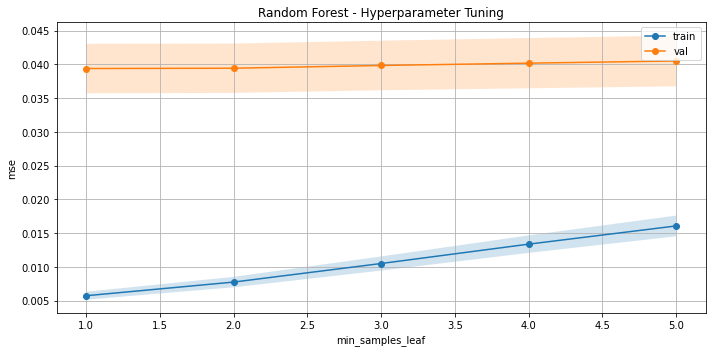

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))
plot_2d_tuning_plot(
    name_hyperparameter="min_samples_leaf",
    name_metric="mse",
    name_model="Random Forest",
    hyperparams=results_df.index,
    mean_score_train=results_df["mse_train_mean"],
    mean_score_val=results_df["mse_val_mean"],
    std_score_train=results_df["mse_train_std"],
    std_score_val=results_df["mse_val_std"],
    ax=ax,
    marker="o",
)
fig.tight_layout()
fig.savefig(os.path.join("out", "task_4_rf_tuning.pdf"), bbox_inches="tight")


#### 2.2 Final training with best hyperparameters

In [6]:
best_min_leaf_tree = results_df["mse_val_mean"].idxmin()
model = RandomForestRegressor(random_state=42, min_samples_leaf=best_min_leaf_tree)
model.fit(X_learn, y_learn)
r2_train = model.score(X_learn, y_learn)
mse_train = mean_squared_error(y_learn, model.predict(X_learn))

print(f"R2 train: {r2_train}")
print(f"MSE train: {mse_train}")


R2 train: 0.9888696031098916
MSE train: 0.0010942264047481601


### 3. Test final performance

In [8]:
y_pred = model.predict(X_test)


In [9]:
r2_test = model.score(X_test, y_test)
mse_test = mean_squared_error(y_test, y_pred)

print(f"R2 test: {r2_test}")
print(f"MSE test: {mse_test}")


R2 test: 0.9244752067578718
MSE test: 0.00728737792335161


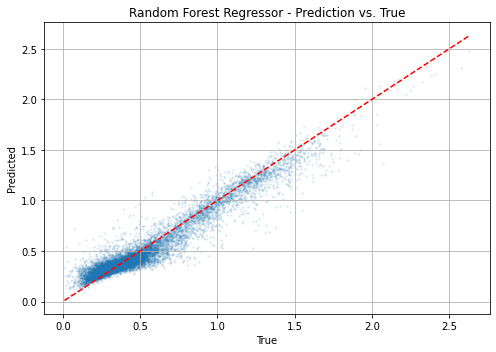

In [11]:
fig, ax = plt.subplots(figsize=(7, 5))
prediction_scatter(y_pred, y_test, "Random Forest Regressor - Prediction vs. True", ax=ax, alpha=0.1, s=2)
fig.tight_layout()
fig.savefig(os.path.join("out", "task_4_rf_prediction_scatter.png"), bbox_inches="tight", dpi=600)


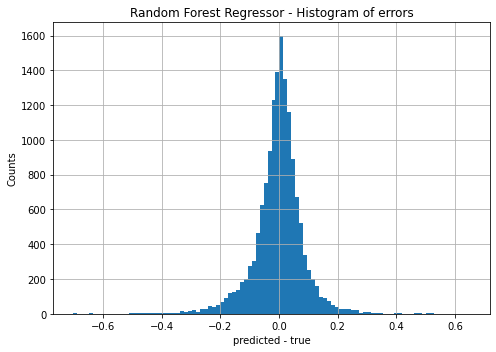

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))
simple_histogram(
    y_pred - y_test,
    title="Random Forest Regressor - Histogram of errors",
    xlabel="predicted - true",
    num_bins=100,
    ax=ax,
)
fig.tight_layout()
fig.savefig(os.path.join("out", "task_4_rf_histogram.pdf"), bbox_inches="tight")


### 4. Export Test results

In [20]:
pickle.dump(y_pred, open(os.path.join("out", "task_4_rf_pred_test.pkl"), "wb"))


In [21]:
pickle.load(open(os.path.join("out", "task_4_rf_pred_test.pkl"), "rb"))


array([1.10985123, 0.25508268, 0.28042024, ..., 0.35172339, 1.22123505,
       0.48623231])